In [1]:
import subprocess
import configparser

import matplotlib.pyplot as plt
import pickle
import numpy as np
import os

if not os.path.isdir('./graphs'):
    os.makedirs('./graphs')

import math

#plt.style.use("ggplot")

class Trader:
    pass

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == 'Trader':
            return Trader
        return super().find_class(module, name)

In [ ]:
def plot_expectations(filename):
    data = CustomUnpickler(open(os.path.join('./output', filename),'rb')).load()
    #trades = data['assets'][0].trades
    #print(len(trades))
    #print(sum([trade.buyer == trade.seller for trade in trades]))
    #fig, axs = plt.subplots(4, sharex=True, sharey=True)
    for i in range(0,4):
        names = []
        for j in range(0,4):
            agent = data['agents'][j]
            if(hasattr(agent, 'expectations')):
                expectations = agent.expectations
                plt.plot(expectations[:,0],expectations[:,i+1])
                names.append(agent.name)
        plt.ylabel('value')
        plt.xlabel('time')
        plt.legend(labels = names)
        titlestring = 'Agents\' view of suit '+str(i)+'\'s value over time'
        if i == data['goalsuit']:
            titlestring += " (GOAL SUIT)"
        plt.title(titlestring)
        plt.show()

In [223]:
def plot_rewards(input_base, iterations, output):
    endcash = np.zeros([iterations,4])
    endpayout = np.zeros([iterations,4])
    avg_trades = 0
    for i in range(0, iterations):
        filename = os.path.join('./output',input_base+'.'+str(i))
        data = CustomUnpickler(open(filename, 'rb')).load()
        cash = [agent.cash for agent in data['agents']]
        payout = [agent.payout for agent in data['agents']]
        names = [agent.name for agent in data['agents']]
        endcash[i,:] = cash
        endpayout[i,:] = payout
        avg_trades += sum([len(asset.trades) for asset in data["assets"]])/iterations
    cashmeans = np.mean(endcash,axis=0)
    payoutmeans = np.mean(endpayout,axis=0)
    print(cashmeans)
    cashstds  = np.std(endcash,axis=0)
    payoutstds  = np.std(endpayout,axis=0)
    print(payoutmeans)
    #print(endpayout)
    #print(payoutstds)

    fig, ax = plt.subplots()
    color = [agent.color for agent in data['agents']]
    ax.bar(range(0,4),cashmeans,color = color, edgecolor = "black")
    ax.errorbar(range(0,4), cashmeans, yerr = cashstds*2/math.sqrt(iterations),fmt="none", color="grey",capsize=5)
    ax.bar(range(0,4),payoutmeans,color = color,bottom=cashmeans, edgecolor = "black")
    ax.errorbar(range(0,4), payoutmeans+cashmeans, yerr=payoutstds*2/math.sqrt(iterations), fmt="none", color="black",capsize=5)
    ax.set_ylim((0,600))
    ax.set_ylabel("Mean cash + payout at end")
    ax.set_xlabel("Player")
    ax.set_xticks(range(0,4))
    ax.set_xticklabels(names)

    plt.show()
    fig.savefig('graphs/'+output+".png", facecolor='white', transparent=False)

In [202]:
iterations = 100

In [203]:
for i in range(1, 4):
    print(i)
    config = configparser.ConfigParser()
    config['fundamental'] = {'source': 'fundamentalist',
                             'n':i,
                             'cash': 350}
    prey = [k for k in range(0,i)]
    config['bottomfeeder'] = {'source': 'bottomfeeder_v2',
                              'n':1,
                              'cash': 350,
                              'params':{'prey': prey, 'ordersno': 4}}
    config['noisy'] = {'source': 'noise',
                       'n':4-i-1,
                       'cash': 350,
                       'params': '{\'var\': 1, \'horizon\': 50}'}
    with open('configs/temp_config.ini', 'w') as configfile:
        config.write(configfile)
    for j in range(0, iterations):
        subprocess.run(['./market-des', '-r figgie -s 10000', '--index '+str(j),
               '--output '+'bvsf.'+str(i), '--config '+"temp_config"],stdout=subprocess.DEVNULL)


1
2
3


In [ ]:
for i in range(1, 4):
    filename = 'bvsf'+'.'+str(i)
    print(i)
    plot_rewards(filename, iterations, filename)

1


In [205]:
configs = ['4n','1f3n','2f2n','3f1n','4f']
iterations = 100

In [206]:
for config in configs:
    print(config)
    for i in range(0, iterations):
        subprocess.run(['./market-des', '-r figgie -s 10000', '--index '+str(i),
                       '--output '+config, '--config '+config],stdout=subprocess.DEVNULL)

4n
1f3n
2f2n
3f1n
4f


4n
[353.33547912 349.39433465 346.42304293 350.8471433 ]
[51.9        51.13333333 45.43333333 51.53333333]


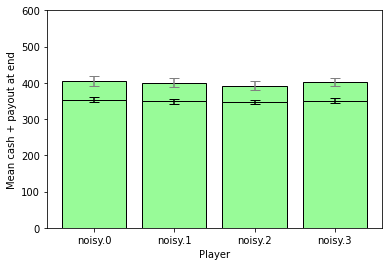

1f3n
[371.22861121 333.11908478 353.58806055 342.06424346]
[158.03333333  11.33333333  11.83333333  18.8       ]


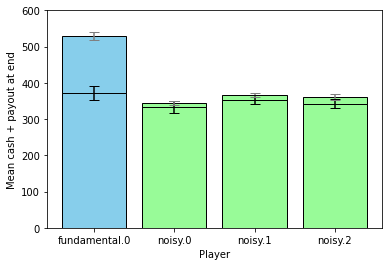

2f2n
[414.3237244  422.88469149 292.53538199 270.25620212]
[84.3 75.3 16.8 23.6]


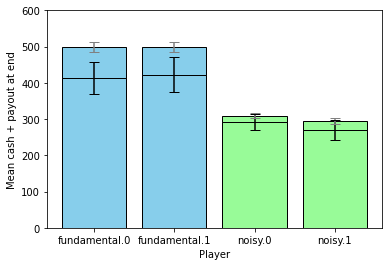

3f1n
[408.14995167 418.91381042 394.37857241 178.55766551]
[62.3 52.8 56.  28.9]


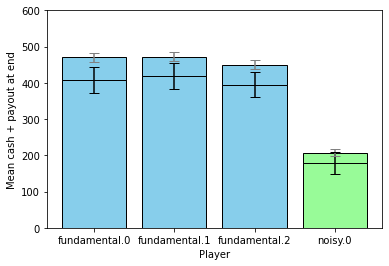

4f
[368.54151832 368.06939488 326.32965686 337.05942994]
[47.7 53.6 49.4 49.3]


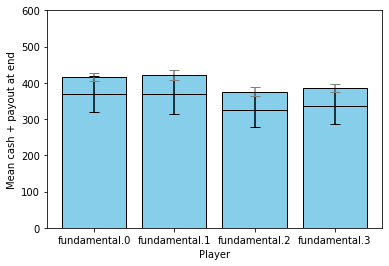

In [222]:
for config in configs:
    print(config)
    plot_rewards(config, iterations, config)

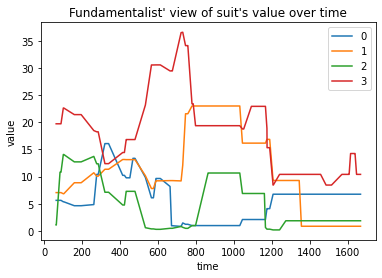

In [208]:
data = CustomUnpickler(open(os.path.join('./output', '1f3n.4'),'rb')).load()
data = data['agents'][0].expectations
data = data[1:100,:]
for i in range(1,5):
    plt.plot(data[:,0],data[:,i])
plt.ylabel('value')
plt.xlabel('time')
plt.legend(labels = range(0,4))
plt.title('Fundamentalist\' view of suit\'s value over time')
plt.show()

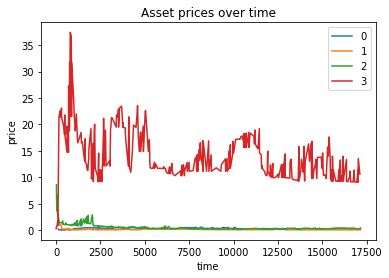

In [209]:
data = CustomUnpickler(open(os.path.join('./output', '1f3n.4'),'rb')).load()
for i in range(0,4):
    asset = data['assets'][i]
    price_series = asset.price_series
    times = price_series[:,0]
    prices = price_series[:,1]
    plt.plot(times,prices)
plt.ylabel('price')
plt.xlabel('time')
plt.title('Asset prices over time')
plt.legend(labels = range(0,4))
plt.show()

In [210]:
iterations=100
config = 'bottomfeeders'
for i in range(0, iterations):
    subprocess.run(['./market-des', '-r figgie -s 10000', '--index '+str(i),
                   '--output '+config, '--config '+config],stdout=subprocess.DEVNULL)

[254.71804154 366.67811396 387.80294655 390.80089794]
[177.6  16.3   4.6   1.5]


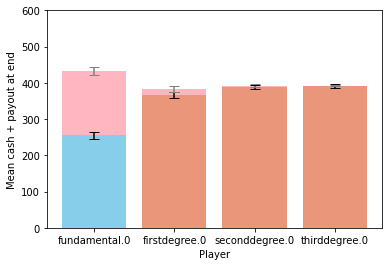

In [211]:
plot_rewards('bottomfeeders',iterations,"bottomfeeders")

In [213]:
iterations=100
config = 'bottomfeeders_v2'
for i in range(0, iterations):
    subprocess.run(['./market-des', '-r figgie -s 10000', '--index '+str(i),
                   '--output '+config, '--config '+config],stdout=subprocess.DEVNULL)

[443.67197834 392.32634071 322.58023605 241.4214449 ]
[60.2        39.43333333 38.83333333 61.53333333]


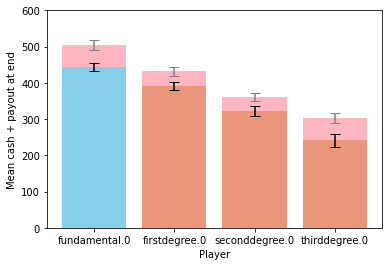

In [214]:
plot_rewards('bottomfeeders_v2',iterations,"bottomfeeders_v2")

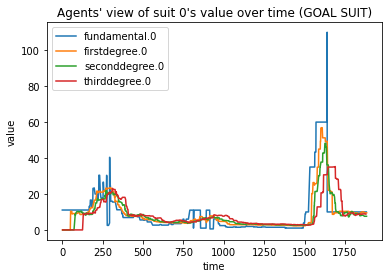

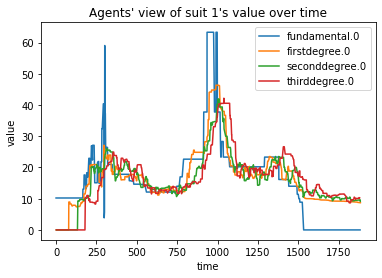

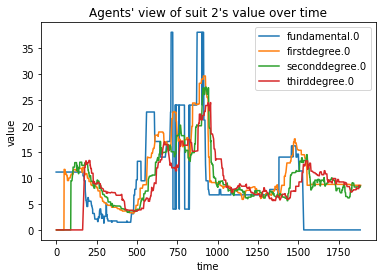

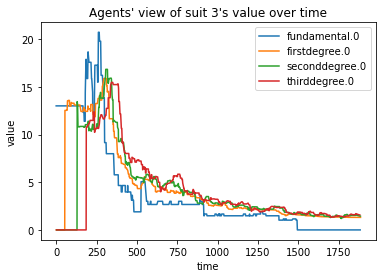

In [194]:
#     orders = data['agents'][0].orders
#     orders = [order for order in orders if order.assetno == 0]
#     order_prices = [order.price for order in orders]
#     colors = ["red" if order.buy else "green" for order in orders]
#     plt.scatter(range(0,len(orders)),order_prices,color = colors)
#     plt.show()
plot_expectations('bottomfeeders_v2.0')

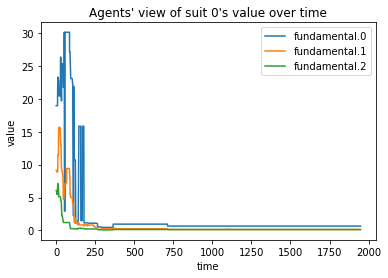

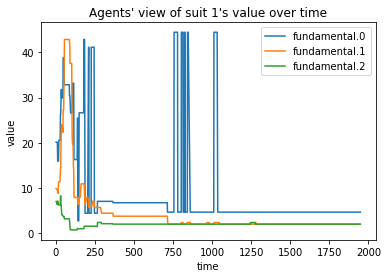

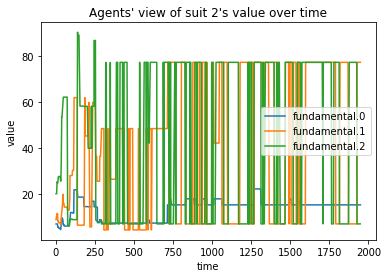

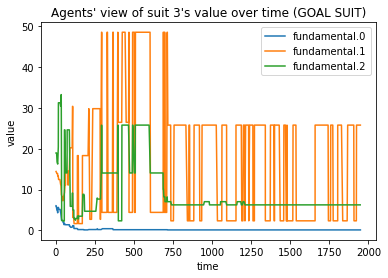

In [198]:
plot_expectations('3f1n.0')